In [1]:
# Define critical control variables

# Min/max values used to scale the height, lon, and lat
scale_minimum = 0
scale_maximum = 1

In [2]:
# Common imports
import os
from pathlib import Path

import numpy as np
import pandas as pd


In [3]:
# Plotting
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt


In [4]:
# Import functions from the utilities file
from TZVOLCANO_utilities import *

# Early version of chords GUI interface
from chords_gui import chords_gui 

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [5]:
# Render the data download widget
domain = 'tzvolcano.chordsrt.com'
chords = chords_gui(domain)

# Define the initial start and end date for the date selector
start_date_string = '2021-01-01'
end_date_string = '2021-01-05'

# Generate the uer interface
chords.start_end_widgets(start_date_string, end_date_string)

Output()

In [6]:
chords.select_data_file()

Available Data Files


Output()

In [119]:
# Read the fileselected file to use
file_name = chords.available_data_files.value
print("Imported csv dat from" + file_name)

unmodified_data = chords.load_data_from_file(file_name)
print(unmodified_data.keys())
print(type(unmodified_data['Time']))
print(type(unmodified_data['Time'][0]))
# unmodified_data

Imported csv dat fromtzvolcano_chordsrt_com_instrument_id_1_2021-01-01_to_2021-01-01.csv
csv_files/tzvolcano_chordsrt_com_instrument_id_1_2021-01-01_to_2021-01-01.csv
Index(['Time', 'Latitude', 'Longitude', 'Height'], dtype='object')
<class 'pandas.core.series.Series'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>


In [263]:
# Fill in missing points in the time series

resampled_data = unmodified_data.copy()

# resampled_data['Timestamp'] = resampled_data['Time']

# Fill in missing times
resampled_data = resampled_data.set_index('Time').sort_index().resample('1000ms').ffill()
resampled_data['Time'] = resampled_data.index

# resampled_data['Time'] = unmodified_data.sort_index().resample('1000ms').ffill()
print(str(resampled_data['Time'].size - unmodified_data['Time'].size) + " missing points filled with NaN")

print(resampled_data.keys())


34890 missing points filled with NaN
Index(['Latitude', 'Longitude', 'Height', 'Time'], dtype='object')


In [234]:
# Scale the data

scaled_data = pd.DataFrame()

# Convert the Time variable to Seconds Since Epoch
scaled_data["Seconds Since Epoch"] = resampled_data['Time'].astype(np.int64)
# scaled_data["Time"] = resampled_data['Time']

# Rescale Height, Longitude and Latitude to the range between scale_minimum and scale_maximum
scaled_data["Scaled Height"] = scale_np_data(resampled_data["Height"].to_numpy(), scale_minimum, scale_maximum)
scaled_data["Scaled Latitude"] = scale_np_data(resampled_data["Latitude"].to_numpy(), scale_minimum, scale_maximum)
scaled_data["Scaled Longitude"] = scale_np_data(resampled_data["Longitude"].to_numpy(), scale_minimum, scale_maximum)


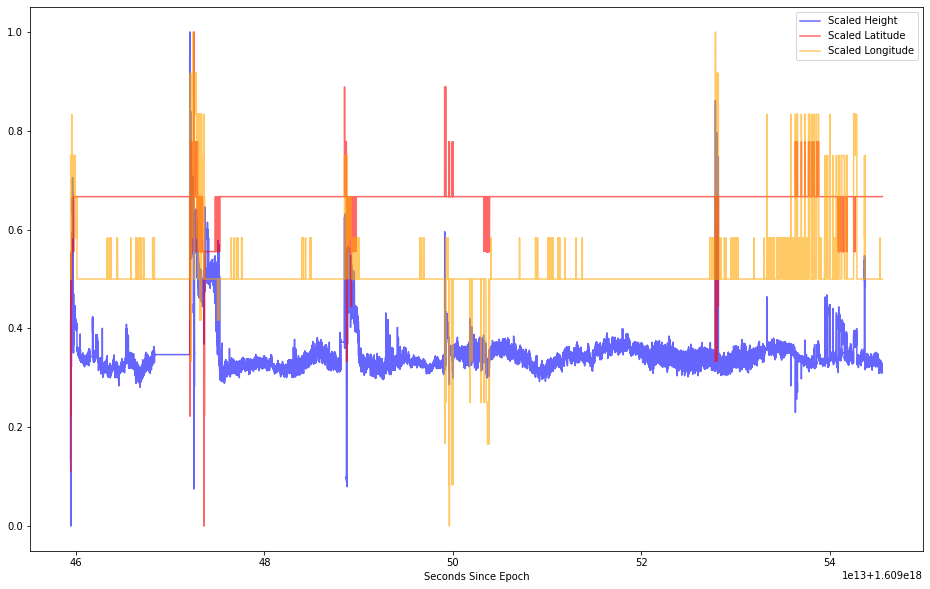

In [231]:
plt.figure(figsize=(16, 10))

# get current axis
ax = plt.gca()
alpha = 0.6

scaled_data.plot(kind='line',x='Seconds Since Epoch',y='Scaled Height', color='blue',ax=ax, alpha=alpha)
scaled_data.plot(kind='line',x='Seconds Since Epoch',y='Scaled Latitude', color='red', ax=ax, alpha=alpha)
scaled_data.plot(kind='line',x='Seconds Since Epoch',y='Scaled Longitude', color='orange', ax=ax, alpha=alpha)

plt.show()

In [260]:
def calculate_scalar(pandas_object, vector_fields_list):
    # create the string to evaluate
    strings =[]
    for vector_field in vector_fields_list:
        string_partial = "pandas_object['" + vector_field + "']**2"
        strings.append(string_partial)
    
    s = " + "
    string = s.join(strings)
    
    scalar_value = np.sqrt(eval(string))
#     scalar_value = np.sqrt(eval("0.2"))
#     scalar_value = np.sqrt(0.2)
    
    normalized_scalar_value = scale_np_data(scalar_value.to_numpy(), scale_minimum, scale_maximum)

    return normalized_scalar_value

vector_fields_list = ['Scaled Height', 'Scaled Latitude', 'Scaled Longitude']

scaled_data["Average Scalar"] = calculate_scalar(scaled_data, vector_fields_list)

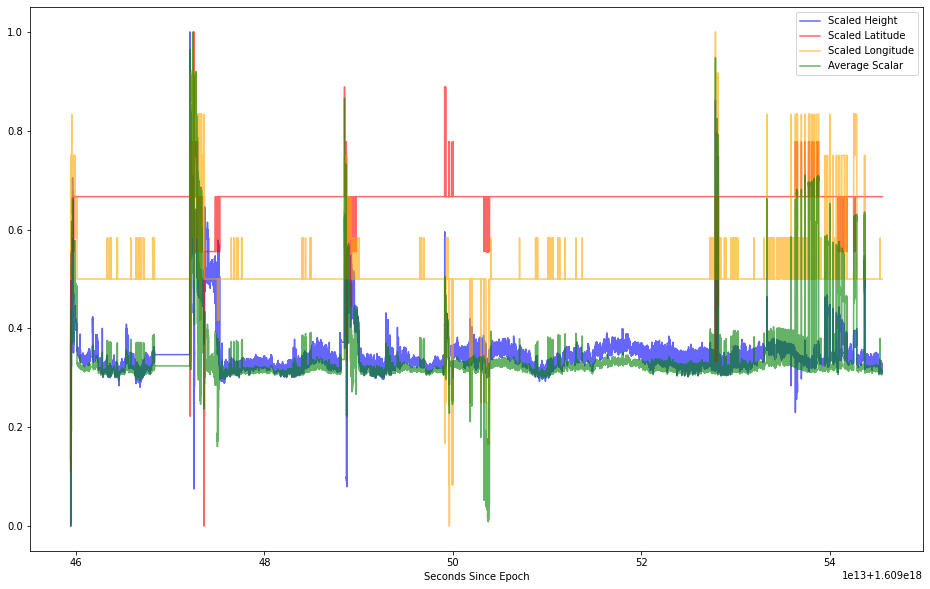

In [261]:
plt.figure(figsize=(16, 10))

# get current axis
ax = plt.gca()
alpha = 0.6

scaled_data.plot(kind='line',x='Seconds Since Epoch',y='Scaled Height', color='blue',ax=ax, alpha=alpha)
scaled_data.plot(kind='line',x='Seconds Since Epoch',y='Scaled Latitude', color='red', ax=ax, alpha=alpha)
scaled_data.plot(kind='line',x='Seconds Since Epoch',y='Scaled Longitude', color='orange', ax=ax, alpha=alpha)

scaled_data.plot(kind='line',x='Seconds Since Epoch',y='Average Scalar', color='green', ax=ax, alpha=alpha)

plt.show()